<a href="https://colab.research.google.com/github/ali-rabiee/Portfolio-Formation/blob/main/Portfolio_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Libraries

In [ ]:
!pip install keras-rl
# !pip install gym
# !pip install rl==2.4
!pip install keras-rl2
# !pip install Callbacks 
# !pip install callbacks
# !pip install rl.callbacks
# !pip install tf-nightly
# !pip install yfinance
# !pip install minisom
# !pip uninstall tensorflow --yes
# !pip uninstall keras --yes
# !pip install tensorflow==1.15
# !pip install keras==1.2.2

# Google Drive Connection

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('drive/My Drive/Colab Notebooks/DQN')

Mounted at /content/drive/


# Get Data

In [ ]:
# Name of 60 Stocks  
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

print(f"Number of Stocks: {len(stocks)}")

Number of Stocks: 57


In [ ]:
from get_stock import get_stock

# Getting Data

start = "2020-05-10"
end = "2022-04-29"

for ticker in stocks:
    # Download datasets
    print(f'### Downloading {ticker}:')
    Hour = get_stock(ticker, start, end, "60m")
    Day = get_stock(ticker, start, end, "1d")
    Week = get_stock(ticker, start, end, "1wk")
    
    # Reset indexes
    Hour.reset_index(drop=True, inplace=True)
    Day.reset_index(drop=True, inplace=True)
    Week.reset_index(drop=True, inplace=True)

    # Save the datasets
    PATH = "datasets/"
    Hour.to_csv(f"{PATH}{ticker}hour.csv")
    Day.to_csv(f"{PATH}{ticker}day.csv")
    Week.to_csv(f"{PATH}{ticker}week.csv")
    

# Train the DQN Model

The code needs three positional parameters to be correctly executed: \\
python main.py [numberOfActions, isOnlyShort, ensembleFolder]


* To run the FULL agent you need to run: python main.py 3 0 ensembleFolder
* To run the ONLY LONG agent you need to run: python main.py 2 0 ensembleFolder
* To run the ONLY SHORT agent you need to run: python main.py 2 1 ensembleFolder \\
where the paramenter ensembleFolder is used to set the name of the folder in which you'll get your results.

In [ ]:
"""This is the class call for the Agent which will perform the experiment"""

import keras
import tensorflow as tf
#This is the class call for the Agent which will perform the experiment
from deepQTrading import DeepQTrading

# Date library to manipulate time in the source code
import datetime

# Keras library to define the NN to be used
from keras.models import Sequential

# Layers used in the NN considered
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda

# Activation Layers used in the source code
from keras.layers import LeakyReLU, Input

# Optimizer used in the NN
# from keras.optimizers import Adam

#Libraries used for the Agent considered
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy


#Library used for showing the exception in the case of error 
import sys

import pandas as pd
import numpy as np
from evaluation import perc_ensemble, full_ensemble, ensemble


'''
There are three actions possible in the stock market
Hold(id 0): do nothing.
Long(id 1): It predicts that the stock market value will raise at the end of the day. 
So, the action performed in this case is buying at the beginning of the day and sell it at the end of the day (aka long).
Short(id 2): It predicts that the stock market value will decrease at the end of the day.
So, the action that must be done is selling at the beginning of the day and buy it at the end of the day (aka short). 
//////////////////////////////////////////////////////////////
The Model is a simple NN considered. It is composed of:
One flatten layer to get 68 dimensional vectors as input
One dense layer with 35 neurons and LeakyRelu activation
One final Dense Layer with the 3 actions considered
the input is 20 observation days from the past, 8 observations from the past week and 
40 observations from the past hours
//////////////////////////////////////////////////////////////
Define the DeepQTrading class with the following parameters:
explorations: 0.2 operations are random, and 100 epochs.
in this case, epochs parameter is used because the Agent acts on daily basis, so its better to repeat the experiments several
times so, its defined that each epoch will work on the data from training, validation and testing.
trainSize: the size of the train data gotten from the dataset, we are setting 5 stock market years, or 1800 days
validationSize: the size of the validation data gotten from dataset, we are setting 6 stock market months, or 180 days
testSize: the size of the testing data gotten from dataset, we are setting 6 stock market months, or 180 days
outputFile: where the results will be written
begin: where the walks will start from. We are defining January 1st of 2010
end: where the walks will finish. We are defining February 22nd of 2019
nOutput:number of walks
'''
# Set Parameters
nb_actions = 3
isOnlyShort = 0
ensembleFolderName = "ensembleFolder"


model = Sequential()
model.add(Flatten(input_shape=(1, 1, 68)))
model.add(Dense(35,activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(nb_actions))
model.add(Activation('linear'))


stocks = ['TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

for ticker in stocks:

    print(f"\n#### Train {ticker} ####\n")
    # Define the DeepQTrading class
    dqt = DeepQTrading(
        ticker=ticker,
        model=model,
        explorations=[(0.2, 50)],
        trainSize=datetime.timedelta(days=30*19),
        validationSize=datetime.timedelta(days=30*1),
        testSize=datetime.timedelta(days=30*1),
        outputFile="Output/csv/walks/walks",
        begin=datetime.datetime(2020, 6, 30, 0, 0, 0, 0),
        end=datetime.datetime(2022, 4, 1, 0, 0, 0, 0),
        nbActions=nb_actions,
        isOnlyShort=isOnlyShort,
        ensembleFolderName=ensembleFolderName
        )
    numWalks = dqt.run()
    dqt.end()

    # Preparing and saving the results
    numDel = 0
    for j in range(0, numWalks):

        df_test = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_test_{ticker}.csv", index_col='Date')
        df_valid = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_valid_{ticker}.csv", index_col='Date')

        for deleted in range(1, numDel):
            del df_test['iteration'+str(deleted)]
            del df_valid['iteration'+str(deleted)]

        if j == 0:
            fulldf_test = perc_ensemble(df_test)
            fulldf_valid = perc_ensemble(df_valid)

        else:
            fulldf_test = fulldf_test.append(perc_ensemble(df_test))
            fulldf_valid = fulldf_valid.append(perc_ensemble(df_valid))


    metrics_test = ensemble(numWalks, ticker, data_type='test', numDel=5)
    metrics_valid = ensemble(numWalks, ticker, data_type='valid', numDel=5)

    method = "short" if isOnlyShort == 1 else "long"
    method = '3act' if nb_actions == 3 else method 

    # Save Predictions
    PATH = "./Output/results/DQN predictions/"
    fulldf_test.to_csv(f"{PATH}{ticker}_{method}_preds_test.csv")
    fulldf_valid.to_csv(f"{PATH}{ticker}_{method}_preds_valid.csv")

    # Save metrics
    PATH = "./Output/results/DQN metrics/"
    metrics_test.to_csv(f"{PATH}{ticker}_{method}_metrics_test.csv")
    metrics_valid.to_csv(f"{PATH}{ticker}_{method}_metrics_valid.csv")


#### Train TSM ####



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Streaming output truncated to the last 5000 lines.
31 TRAIN:  acc: 0.8181818181818182 cov: 0.9166666666666666 rew: 5.036110755847886
Resetted: episode 13; Index 109 over the limit (109)
Resetted: episode 25; Index 109 over the limit (109)
31 VALID:  acc: 0.5 cov: 1.0 rew: 0.011466030018486905
Resetted: episode 18; Index 153 over the limit (153)
31 TEST:  acc: 0.7727272727272727 cov: 0.9166666666666666 rew: 0.20043926165894177
 
Resetted: episode 386; Index 2719 over the limit (2719)
32 TRAIN:  acc: 0.7761557177615572 cov: 0.9013157894736842 rew: 4.433467148696317
Resetted: episode 13; Index 109 over the limit (109)
Resetted: episode 25; Index 109 over the limit (109)
32 VALID:  acc: 0.5 cov: 1.0 rew: 0.011466030018486905
Resetted: episode 18; Index 153 over the limit (153)
32 TEST:  acc: 0.5416666666666666 cov: 1.0 rew: 0.0856527652054998
 
Resetted: episode 386; Index 2719 over the limit (2719)
33 TRAIN:  acc: 0.7836538461538461 cov: 0.9122807017543859 rew: 4.602879814226012
Resetted:

In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 68)            0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 35)            2415        flatten_1[0][0]                  
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 35)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 3)             108         leakyrelu_1[0][0]                
___________________________________________________________________________________________

# Portfolio Selection

## Extract Profitable Stocks

In [ ]:
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

In [ ]:
import pandas as pd

# Ensemble the actions for only-long and only-short agents

data_type = 'valid'

for ticker in stocks:
    # Read the predictions from gdrive 
    preds_long = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_long_preds_{data_type}.csv")
    preds_short = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_short_preds_{data_type}.csv")
    preds_ensemble = []

    # Number of predictions
    N = len(preds_long)

    # Ensemble the only long and only short agents predictions
    for i in range(N):
        if preds_long["ensemble"][i] == 1 and preds_short["ensemble"][i] == 0:
            preds_ensemble.append(1)
        elif preds_long["ensemble"][i] == 0 and preds_short["ensemble"][i] == 2:
            preds_ensemble.append(2)
        else:
            preds_ensemble.append(0) 

    # Create the Dataframe of ensemble predictions
    ensemble_df = preds_long.copy()
    ensemble_df['ensemble'] = preds_ensemble

    # Save 
    PATH = "./Output/results/DQN predictions/"
    ensemble_df.to_csv(f"{PATH}{ticker}_preds_ensemble_{data_type}.csv")

In [ ]:
import pandas as pd
from evaluation import ensemble

In [ ]:
ticker = 'ZNGA'
data_type = 'test'
df = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_preds_ensemble_{data_type}.csv")
ensemble(numWalks=0, ticker=ticker, data_type='test', numDel=0, df=df)

ZeroDivisionError: ignored

In [ ]:
#####################
#     Comparison    #
#####################

In [ ]:
# Extract Profitable stocks in each day

import pandas as pd

method = "short"
data_type = "test"

# Date of the preds
preds = pd.read_csv(f"./Output/results/DQN predictions/{stocks[0]}_preds_{data_type}.csv")
Date = preds_3act["Date"].to_list()
portfolio_ensemble = {}
portfolio_3act = {}
 
for date in Date:
    
    profitable_stocks1 = []
    profitable_stocks2 = []

    for ticker in stocks:
        # Read Predictions
        preds_3act = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_preds_{data_type}.csv")
        preds_long = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_long_preds_{data_type}.csv")
        preds_short = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_short_preds_{data_type}.csv")
        # preds = pd.read_csv(f"./Output/results/predictions/{ticker}_{method}_preds_{data_type}.csv")

        # Get Predictions
        pred_3act = int(preds_3act[preds_3act["Date"] == date]["ensemble"])
        pred_long = int(preds_long[preds_3act["Date"] == date]["ensemble"])
        pred_short = int(preds_short[preds_3act["Date"] == date]["ensemble"])

        if pred_long == 1 and pred_short == 0:
            profitable_stocks1.append(ticker)

        if pred_3act == 1:
            profitable_stocks2.append(ticker)

    portfolio_ensemble[date] = profitable_stocks1
    portfolio_3act[date] = profitable_stocks2

In [ ]:
# Rank the Rewards base on validation set

data_type = 'valid'
columns = ["Iteration", "Reward_Long%", "Reward_Short%", "Reward%", "Wins%", "Losses%", "Coverage%", "Accuracy", "Dataset"]
df_metrics = pd.DataFrame(columns=columns)
for ticker in stocks:
    metrics = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_metrics_{data_type}.csv")
    metrics = metrics[[metrics['Iteration']=='sum']] 
    metrics['Dataset'] = ticker
    df_metrics.append(metrics)

## Correlation

In [ ]:
from clustering import calculate_correlation, visualize_clusters
import datetime

# Calculate the correlation of time series from the base for last num days
base = "2020-10-25"
base = datetime.datetime.strptime(base, '%Y-%m-%d')
numdays = 30
som_x, som_y, win_map, clusters = calculate_correlation(base, numdays)

In [ ]:
# Visualization
visualize_clusters(som_x, som_y, win_map)

## Predict Return

In [ ]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers import LeakyReLU, Input, Dense, GRU, Dropout, LSTM, Layer, BatchNormalization
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model
# from keras.optimizers import Adam
import time

In [ ]:
# Define a def for evaluating Models

def evaluate_model(y_pred, y_gt):
    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_gt, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_gt, y_pred)/ y_gt))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_gt, y_pred)/ y_gt)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %') 


In [ ]:
# Adding Predicted Actions by DQN to dataset 

# # Adding rewards to dataset 
# stocks = ["AAPL"]

# for ticker in stocks:
#     df = pd.read_csv(f'./datasets/{ticker}day.csv')
#     reward = []
#     for i in range(len(df)):
#         reward_day = (df["Close"][i] - df["Open"][i]) / df["Open"][i]
#         if reward_day < 0:
#             reward_day = 0
#         reward.append(reward_day)
#     df["reward"] = reward

# df

### Feature Engineering and Preprocessing

In [ ]:
# Choose the Stock
ticker = 'AAPL'
df = pd.read_csv(f'./datasets/{ticker}day.csv')

# Select Features
df = df[['Close', 'Open', 'Volume', 'High', 'Low']]
features_num = len(df.columns)
features_name = df.columns
print(f"Number of Features: {features_num}")
print(f"Features: {features_name}")

# Select the column that you want to predict
predicted_col = 'Close'
df['Predictions'] = df[predicted_col]
df

Number of Features: 5
Features: Index(['Close', 'Open', 'Volume', 'High', 'Low'], dtype='object')


,Close,Open,Volume,High,Low,Predictions
0,78.752502,77.025002,145946400,79.262497,76.809998,78.752502
1,77.852501,79.457497,162301200,79.922501,77.727501,77.852501
2,76.912498,78.037498,200622400,78.987503,75.802498,76.912498
3,77.385002,76.127502,158929200,77.447502,75.382500,77.385002
4,76.927498,75.087502,166348400,76.974998,75.052498,76.927498
...,...,...,...,...,...,...
492,161.789993,166.460007,84775200,167.869995,161.500000,161.789993
493,162.880005,161.119995,96046400,163.169998,158.460007,162.880005
494,156.800003,162.250000,95623200,162.339996,156.720001,156.800003
495,156.570007,155.910004,88063200,159.789993,155.380005,156.570007


In [ ]:
# Separate the Training and the test sets
dataset_size = len(df)
training_size = round(dataset_size * 0.80)
training_set = df.iloc[:training_size, :]
test_set = df.iloc[training_size:, :]

# Select Features
features_train = training_set.iloc[:, :].values
features_test = test_set.iloc[:, :].values

# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(features_train)
test_set_scaled = sc.fit_transform(features_test)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
predictions_scaled = scaler_pred.fit_transform(df[['Predictions']])


# Creating the train data structure
look_back = 10 

X_train = []
y_train = []

for i in range(look_back, training_size):
    X_train.append(training_set_scaled[i - look_back:i,:features_num]) 
    y_train.append(training_set_scaled[i, features_num])

X_train, y_train = np.array(X_train), np.array(y_train)

# Creating the test data structure
X_test = []
y_test = []

for i in range(look_back, dataset_size-training_size):
    X_test.append(test_set_scaled[i - look_back:i,:features_num])
    y_test.append(test_set_scaled[i, features_num]) 

X_test = np.array(X_test)

### LSTM

In [ ]:
lstm = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], features_num)))
lstm.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=256, return_sequences=True))
lstm.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=256, return_sequences=True))
lstm.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=256))
lstm.add(Dropout(0.2))
# Adding the output layer
lstm.add(Dense(units=1))

# Compiling the model
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10, 50)            11200     
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50)               

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Epochs = 500

lstm = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], features_num)))
lstm.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
# Adding the output layer
lstm.add(Dense(units=1))

# Compiling the model
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the Training set
lstm.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = lstm.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

In [ ]:
# Model Summary
print(lstm.summary())

# Evaluate the LSTM Model in predicting Close prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 10.29
Mean Absolute Percentage Error (MAPE): 7.93 %
Median Absolute Percentage Error (MDAPE): 6.92 %


In [ ]:
# Evaluate the LSTM Model in predicting Open prices
evaluate_model(y_pred, y_test_unscaled)

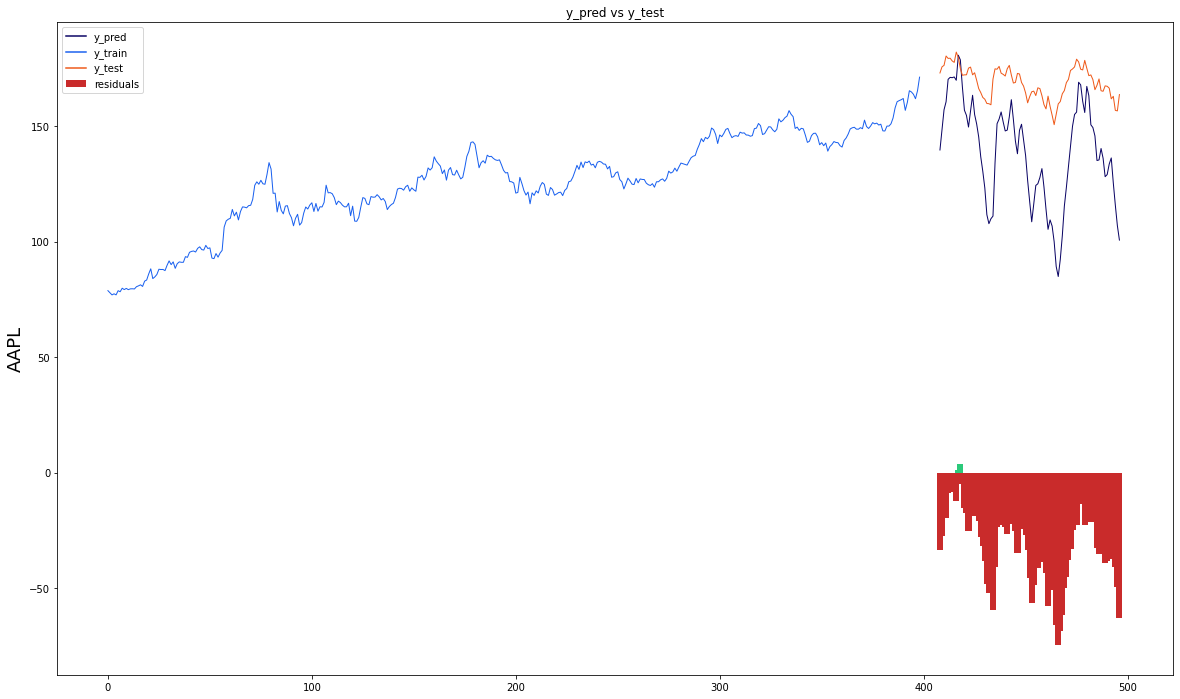

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

### LSTM + GRU

In [ ]:
lstm_gru = Sequential()
# Adding the first GRU layer and some Dropout regularisation
lstm_gru.add(GRU(50, input_shape=(X_train.shape[1], features_num), return_sequences=True))
lstm_gru.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
lstm_gru.add(LSTM(50, return_sequences=True))
lstm_gru.add(Dropout(0.2))
# Adding a third GRU layer and some Dropout regularisation
lstm_gru.add(GRU(50, return_sequences=True))
lstm_gru.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
lstm_gru.add(LSTM(units=50))
lstm_gru.add(Dropout(0.2))
# Adding the output layer
lstm_gru.add(Dense(units=1))

# Summary of the Model
lstm_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 10, 50)            8550      
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 10, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)               

In [ ]:
Epochs = 500

# Compiling the model
lstm_gru.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the Training set
lstm_gru.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = lstm_gru.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

Epoch 1/500
13/13 [==============================] - 10s 24ms/step - loss: 0.1200
Epoch 2/500
13/13 [==============================] - 0s 24ms/step - loss: 0.0257
Epoch 3/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0145
Epoch 4/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0133
Epoch 5/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0093
Epoch 6/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0080
Epoch 7/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0080
Epoch 8/500
13/13 [==============================] - 0s 25ms/step - loss: 0.0084
Epoch 9/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0070
Epoch 10/500
13/13 [==============================] - 0s 25ms/step - loss: 0.0093
Epoch 11/500
13/13 [==============================] - 0s 25ms/step - loss: 0.0075
Epoch 12/500
13/13 [==============================] - 0s 27ms/step - loss: 0.0076
Epoch 13/500
13/13 [====

In [ ]:
# Evaluate the LSTM + GRU Model in predicting Close prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 9.09
Mean Absolute Percentage Error (MAPE): 7.0 %
Median Absolute Percentage Error (MDAPE): 6.22 %


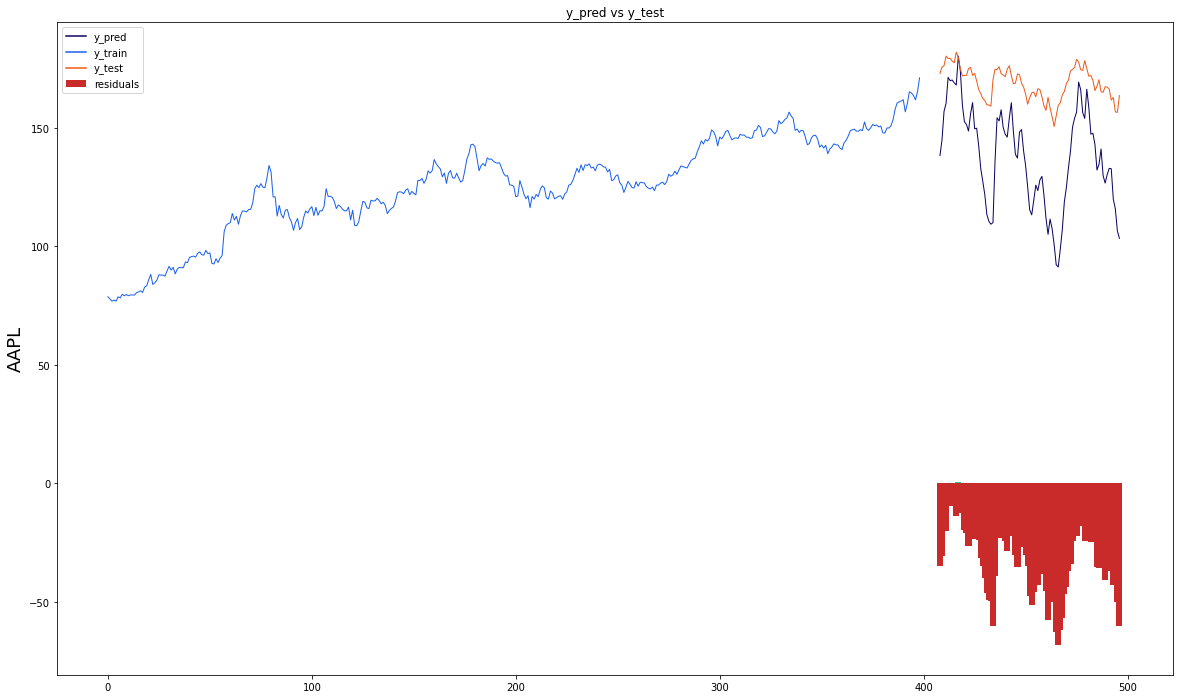

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

### LSTM + Attention

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [ ]:
inp = Input(shape = (X_train.shape[1], features_num))

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

# x = BatchNormalization()(x)
x = Attention(look_back)(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model_lstm_attention = Model(inputs=inp, outputs=x)

model_lstm_attention.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 lstm_21 (LSTM)              (None, 10, 256)           268288    
                                                                 
 dropout_25 (Dropout)        (None, 10, 256)           0         
                                                                 
 batch_normalization_11 (Bat  (None, 10, 256)          1024      
 chNormalization)                                                
                                                                 
 attention_12 (Attention)    (None, 256)               266       
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                           

In [ ]:
Epochs = 1000

# Compiling the model
model_lstm_attention.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the Training set
model_lstm_attention.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = model_lstm_attention.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

Epoch 1/1000
13/13 [==============================] - 4s 66ms/step - loss: 0.4438
Epoch 2/1000
13/13 [==============================] - 1s 83ms/step - loss: 0.1618
Epoch 3/1000
13/13 [==============================] - 1s 73ms/step - loss: 0.1293
Epoch 4/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.0839
Epoch 5/1000
13/13 [==============================] - 1s 40ms/step - loss: 0.0626
Epoch 6/1000
13/13 [==============================] - 0s 37ms/step - loss: 0.0465
Epoch 7/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0422
Epoch 8/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0388
Epoch 9/1000
13/13 [==============================] - 0s 38ms/step - loss: 0.0329
Epoch 10/1000
13/13 [==============================] - 0s 37ms/step - loss: 0.0298
Epoch 11/1000
13/13 [==============================] - 1s 39ms/step - loss: 0.0277
Epoch 12/1000
13/13 [==============================] - 0s 38ms/step - loss: 0.0224
Epoch 13/1000

In [ ]:
# Evaluate the LSTM Model in predicting Close prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 10.09
Mean Absolute Percentage Error (MAPE): 7.77 %
Median Absolute Percentage Error (MDAPE): 7.14 %


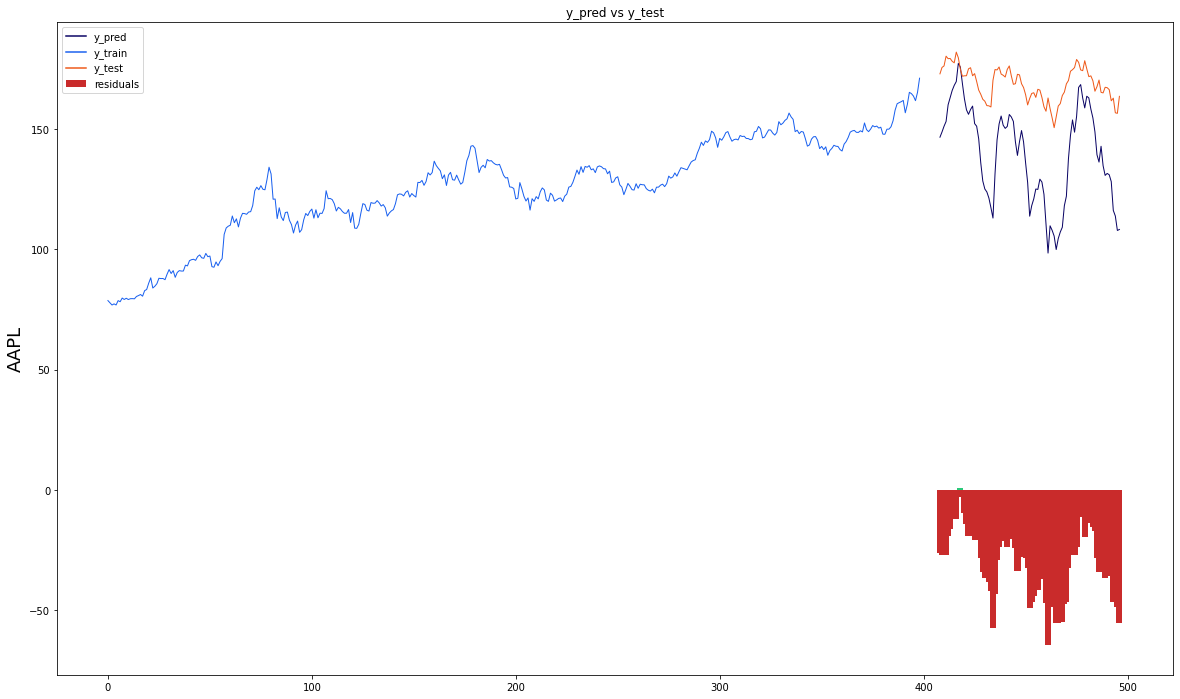

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:

Epochs = 500

lstm_att = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
lstm_att.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], features_num)))
lstm_att.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
lstm_att.add(LSTM(units=64, return_sequences=True))
lstm_att.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
lstm_att.add(LSTM(units=64, return_sequences=True))
lstm_att.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
lstm_att.add(LSTM(units=64))
lstm_att.add(Dropout(0.2))

#Adding the attention layer
# lstm_att.add(SeqSelfAttention())
lstm_att.add(Attention(32))
# Adding the output layer
lstm_att.add(Dense(units=1))

# Compiling the RNN
lstm_att.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the RNN to the Training set
lstm_att.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = lstm_att.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

ValueError: ignored

In [ ]:
# Evaluate the LSTM Model in predicting Open prices
evaluate_model(y_pred, y_test_unscaled)

### GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

Epochs = 500

gru = Sequential()
#Adding the first GRU layer and some Dropout regularisation
gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], features_num)))
gru.add(Dropout(0.2))
# Adding a second GRU layer and some Dropout regularisation
gru.add(GRU(units=50, return_sequences=True))
gru.add(Dropout(0.2))
# Adding a third GRU layer and some Dropout regularisation
gru.add(GRU(units=50, return_sequences=True))
gru.add(Dropout(0.2))
# Adding a fourth GRU layer and some Dropout regularisation
gru.add(GRU(units=50))
gru.add(Dropout(0.2))
# Adding the output layer
gru.add(Dense(units=1))

# Compiling the RNN
gru.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the RNN to the Training set
gru.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = gru.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

Epoch 1/500
13/13 [==============================] - 8s 29ms/step - loss: 0.0906
Epoch 2/500
13/13 [==============================] - 0s 29ms/step - loss: 0.0201
Epoch 3/500
13/13 [==============================] - 0s 29ms/step - loss: 0.0114
Epoch 4/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0093
Epoch 5/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0084
Epoch 6/500
13/13 [==============================] - 0s 29ms/step - loss: 0.0084
Epoch 7/500
13/13 [==============================] - 0s 27ms/step - loss: 0.0081
Epoch 8/500
13/13 [==============================] - 0s 27ms/step - loss: 0.0097
Epoch 9/500
13/13 [==============================] - 0s 27ms/step - loss: 0.0075
Epoch 10/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0073
Epoch 11/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0075
Epoch 12/500
13/13 [==============================] - 0s 26ms/step - loss: 0.0080
Epoch 13/500
13/13 [=====

In [ ]:
# Evaluate the GRU Model in predicting Open prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 9.58
Mean Absolute Percentage Error (MAPE): 7.41 %
Median Absolute Percentage Error (MDAPE): 6.9 %


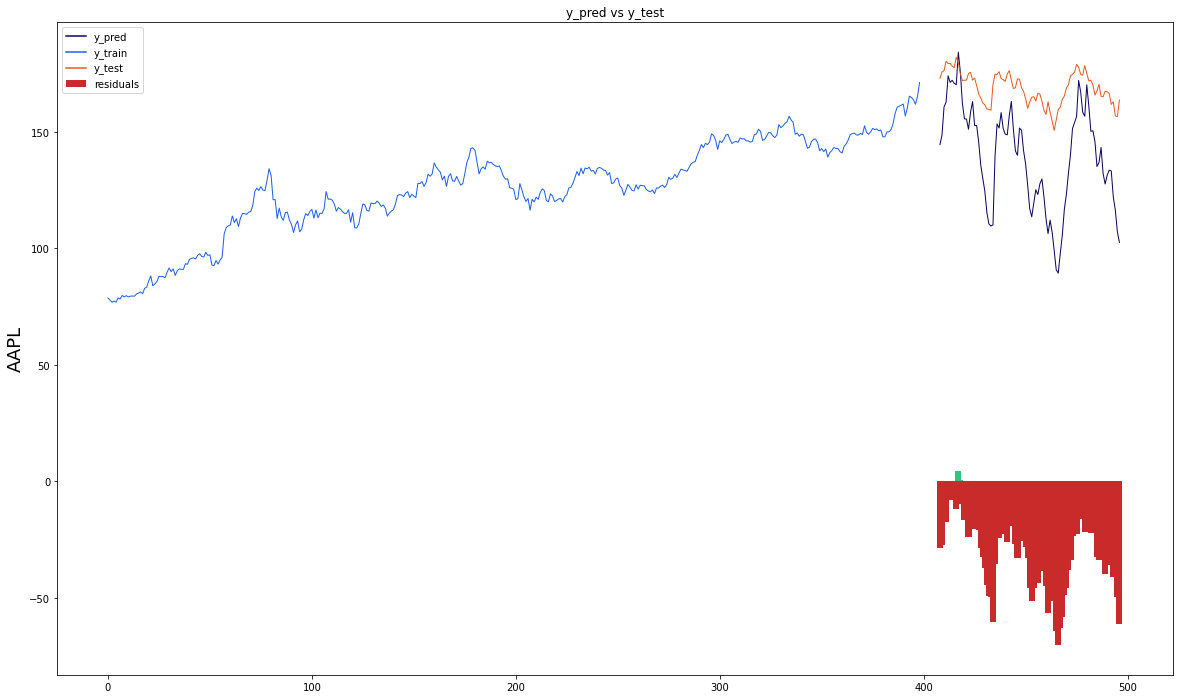

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

### GRU + Attention

In [ ]:
inp = Input(shape = (X_train.shape[1], features_num))

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

# x = BatchNormalization()(x)
x = Attention(look_back)(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model_gru_attention = Model(inputs=inp, outputs=x)

model_gru_attention.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 gru_7 (GRU)                 (None, 10, 256)           201984    
                                                                 
 dropout_35 (Dropout)        (None, 10, 256)           0         
                                                                 
 attention_14 (Attention)    (None, 256)               266       
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 202,507
Trainable params: 202,507
Non-trainab

In [ ]:
Epochs = 500

# Compiling the model
model_gru_attention.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the Training set
model_gru_attention.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = model_gru_attention.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

Epoch 1/500
13/13 [==============================] - 7s 49ms/step - loss: 0.0490
Epoch 2/500
13/13 [==============================] - 0s 38ms/step - loss: 0.0126
Epoch 3/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0081
Epoch 4/500
13/13 [==============================] - 0s 27ms/step - loss: 0.0055
Epoch 5/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0048
Epoch 6/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0044
Epoch 7/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0043
Epoch 8/500
13/13 [==============================] - 0s 31ms/step - loss: 0.0046
Epoch 9/500
13/13 [==============================] - 0s 29ms/step - loss: 0.0046
Epoch 10/500
13/13 [==============================] - 0s 29ms/step - loss: 0.0043
Epoch 11/500
13/13 [==============================] - 0s 31ms/step - loss: 0.0044
Epoch 12/500
13/13 [==============================] - 0s 28ms/step - loss: 0.0046
Epoch 13/500
13/13 [=====

In [ ]:
# Evaluate the LSTM Model in predicting Close prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 13.21
Mean Absolute Percentage Error (MAPE): 9.69 %
Median Absolute Percentage Error (MDAPE): 8.16 %


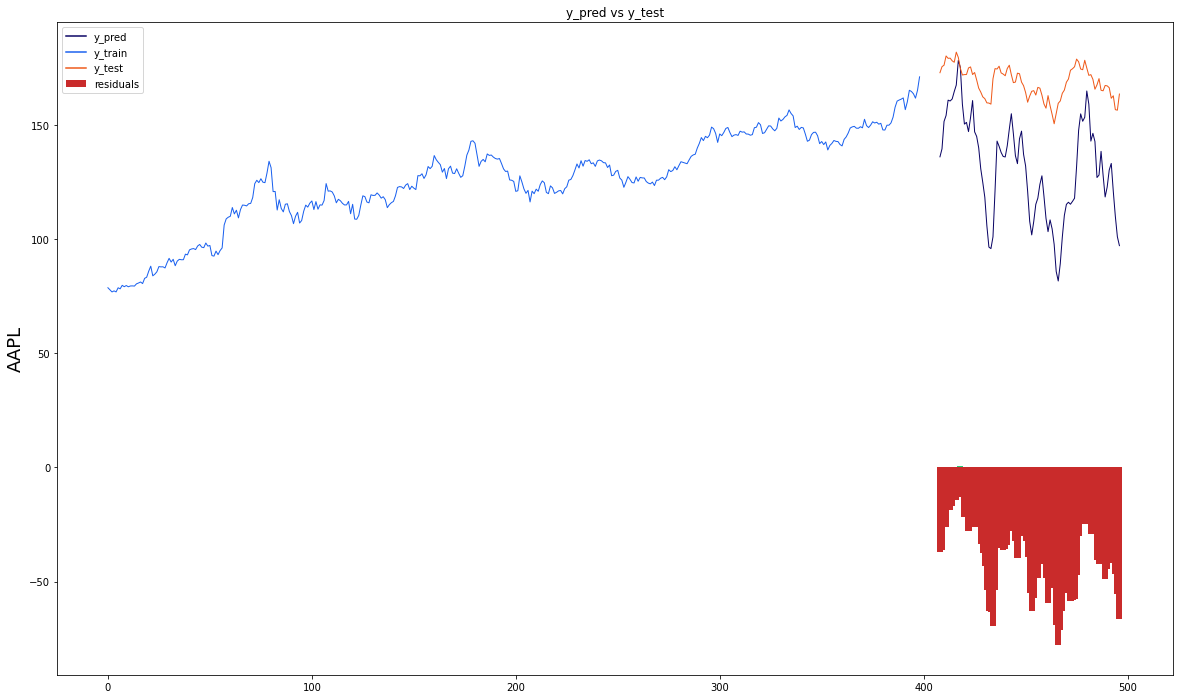

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

### LSTM + GRU + Attention

In [ ]:
inp = Input(shape = (X_train.shape[1], features_num))

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = GRU(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.2)(x)

# x = BatchNormalization()(x)
x = Attention(look_back)(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

lstm_gru_attention = Model(inputs=inp, outputs=x)

lstm_gru_attention.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 10, 5)]           0         
                                                                 
 lstm_25 (LSTM)              (None, 10, 256)           268288    
                                                                 
 dropout_45 (Dropout)        (None, 10, 256)           0         
                                                                 
 attention_16 (Attention)    (None, 256)               266       
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 268,811
Trainable params: 268,811
Non-trainab

In [ ]:
Epochs = 1000

# Compiling the model
lstm_gru_attention.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the Training set
lstm_gru_attention.fit(X_train, y_train, epochs=Epochs, batch_size=32)

# Get the predicted values
y_pred_scaled = lstm_gru_attention.predict(X_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))

Epoch 1/1000
13/13 [==============================] - 5s 62ms/step - loss: 0.0011
Epoch 2/1000
13/13 [==============================] - 1s 65ms/step - loss: 0.0011
Epoch 3/1000
13/13 [==============================] - 1s 56ms/step - loss: 0.0012
Epoch 4/1000
13/13 [==============================] - 1s 56ms/step - loss: 9.9507e-04
Epoch 5/1000
13/13 [==============================] - 1s 78ms/step - loss: 0.0010
Epoch 6/1000
13/13 [==============================] - 1s 64ms/step - loss: 0.0011
Epoch 7/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0011
Epoch 8/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0012
Epoch 9/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0010
Epoch 10/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0011
Epoch 11/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0010
Epoch 12/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0012
Epoch 13/

In [ ]:
# Evaluate the LSTM Model in predicting Close prices
evaluate_model(y_pred, y_test_unscaled)

Median Absolute Error (MAE): 11.27
Mean Absolute Percentage Error (MAPE): 8.28 %
Median Absolute Percentage Error (MDAPE): 6.71 %


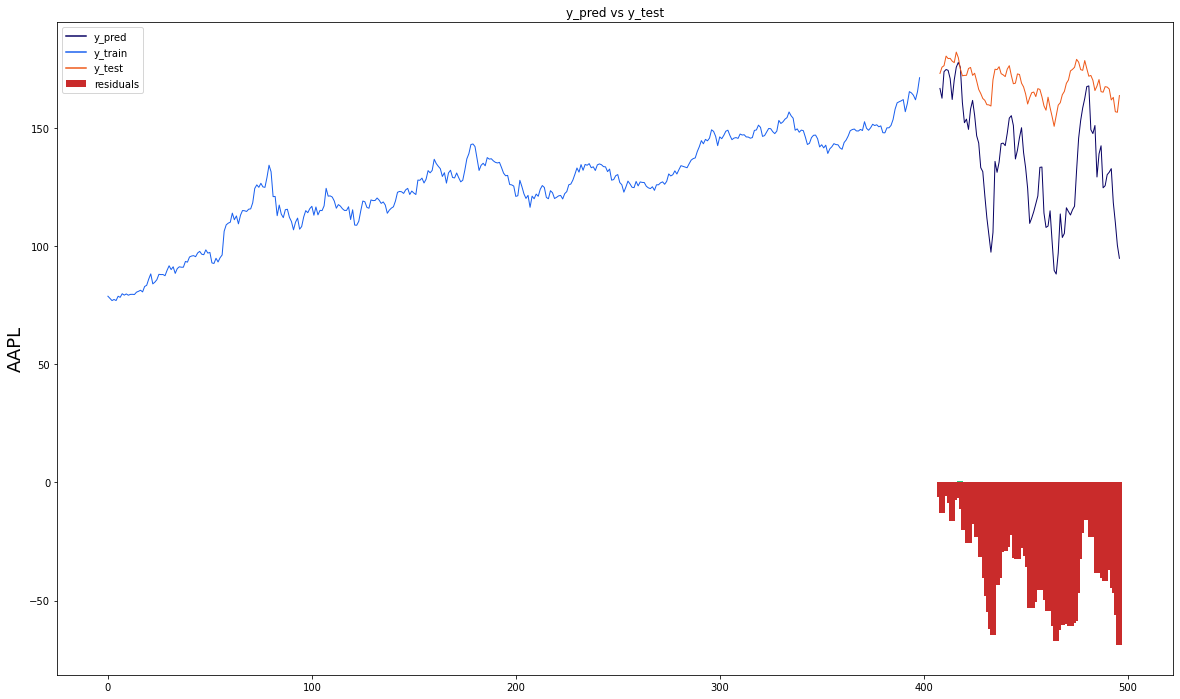

In [ ]:
stockname = 'AAPL'

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df['Close'][:training_size + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df['Close'][training_size+look_back:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(20, 12))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Portfolio Formation

# Trading

In [ ]:
from Trading_Metrics import trade, metrics


# Load the Decisions
actions_long = pd.read_csv("resultEnsembleTest_Long.csv")
actions_short = pd.read_csv("resultEnsembleTest_Short.csv")
df = pd.read_csv("datasets/aaplDay.csv")
# Drop the useless columns
# df = df.reindex(columns = ['Date', 'Open', 'Close'])

In [ ]:
# Environment used for spenv 
# gym is the library of videogames used by reinforcement learning
import gym
from gym import spaces
# Numpy is the library to deal with matrices
import numpy
# Pandas is the library used to deal with the CSV dataset
import pandas
# datetime is the library used to manipulate time and date
from datetime import datetime
# Library created by Tonio to merge data used as feature vectors
from mergedDataStructure import MergedDataStructure
# Callback is the library used to show metrics 
import callback

# This is the prefix of the files that will be opened. It is related to the s&p500 stock market datasets
# MK = "dax"


class SpEnv(gym.Env):
    # Just for the gym library. In a continuous environment, you can do infinite decisions. 
    # We dont want this because we have just three possible actions.
    continuous = False

    # Observation window is the time window regarding the "hourly" dataset 
    # ensemble variable tells to save or not the decisions at each walk
    def __init__(self, ticker, minLimit=None, maxLimit=None, operationCost=0, observationWindow=40, ensamble=None, callback=None, isOnlyShort=False, columnName="iteration-1"):
        # Declare the episode as the first episode
        self.episode = 1

        self.isOnlyShort = isOnlyShort
        self.ticker = ticker
        # Open the time series as the hourly dataset of S&P500
        # the input feature vector is composed of data from hours, weeks and days
        # 20 from days, 8 from weeks and 40 hours, ending with 68 dimensional feature vectors
        hourData = pandas.read_csv('datasets/'+ticker+'hour.csv')[minLimit:maxLimit] # opening the dataset
        
        # Converts each column to a list
        Date = hourData.loc[:, 'Date'].tolist()
        Time = hourData.loc[:, 'Time'].tolist()
        Open = hourData.loc[:, 'Open'].tolist()
        High = hourData.loc[:, 'High'].tolist()
        Low = hourData.loc[:, 'Low'].tolist()
        Close = hourData.loc[:, 'Close'].tolist()
        
        # Open the weekly and daily data as a merged data structure
        # Get 20 dimensional vectors (close-open) considering 20 past days and 8 dimensional vectors (close-open) 
        # considering 8 weeks
        self.weekData = MergedDataStructure(delta=8, filename='datasets/'+ticker+"week.csv")# this DS allows me to obtain previous historical data with different resolution
        self.dayData = MergedDataStructure(delta=20, filename='datasets/'+ticker+"day.csv")#  with low computational complexity
        
        # Load the data
        self.output = False # it will be True if we decide to save the decisions in each epoch & date or self.ensamble is not None

        # ensamble is the table of validation and testing
        # If it is none, you will not save csvs of validation and testing    
        if(ensamble is not None): # managing the ensamble output (maybe in the wrong way)
            self.output = True
            self.ensamble = ensamble
            self.columnName = columnName
            # self.ensemble is a big table (before file writing) containing observations as lines and epochs as columns
            # each column will contain a decision for each epoch at each date. It is saved later.
            # We read this table later in order to make ensemble decisions at each epoch
            self.ensamble[self.columnName] = 0

        # Declare low and high as vectors with -inf values 
        # low and high are the minimun and maximum accepted values in feature vector
        self.low = numpy.array([-numpy.inf])
        self.high = numpy.array([+numpy.inf])

        # Define the space of actions as 3
        # the action space is just 0, 1, 2 which means hold, long, short
        self.action_space = spaces.Discrete(3) 
        
        # low and high are the minimun and maximum accepted values for this problem
        # We don't know what are the minimum and maximum values of Close-Open, so we put these values
        self.observation_space = spaces.Box(self.low, self.high, dtype=numpy.float32)

        # Set observationWindow = 40 (40 hours)
        # Observation window is the time window regarding the "hourly" dataset
        self.observationWindow = observationWindow
        
        # Set the current observation as 40
        self.currentObservation = observationWindow
        # The operation cost is defined as 
        self.operationCost = operationCost
        # Defines that the environment is not done yet
        self.done = False
        # The limit is the number of open values in the dataset (could be any other value): it shows the number of data
        self.limit = len(Open)
        # organizing the hour dataset as a list of dictionaries 
        # The history begins empty
        self.history = []
        for i in range(0, self.limit): 
            self.history.append({'Date' : Date[i],'Time' : Time[i], 'Open': Open[i], 'High': High[i], 'Low': Low[i], 'Close': Close[i]})
        
        # Next observation starts
        self.nextObservation = 0
        
        # self.history contains all the hour data. Here we search for the next day 
        while(self.history[self.currentObservation]['Date']==self.history[(self.currentObservation+self.nextObservation)%self.limit]['Date']):
            self.nextObservation += 1
        
        # Initiates the values to be returned by the environment
        self.reward = None
        self.possibleGain = 0
        self.openValue = 0
        self.closeValue = 0
        self.callback = callback


    # This is the action that is done in the environment. 
    # Receives the action and returns the state, the reward and if its done 
    def step(self, action):
        # Initiates the reward, weeklist and daylist
        self.reward = 0

        if(self.isOnlyShort):
            action *= 2   

        # Set the next observation to zero
        self.nextObservation = 0
        # Search for the close value for tommorow
        while(self.history[self.currentObservation]['Date']==self.history[(self.currentObservation+self.nextObservation)%self.limit]['Date']):
            # Search for the close error for today
            self.closeValue = self.history[(self.currentObservation+self.nextObservation)%self.limit]['Close']
            self.nextObservation += 1

        # Get the open value for today 
        self.openValue = self.history[self.currentObservation]['Open']

        '''
        Reward
        '''
        # Calculate the reward in percentage of growing/decreasing
        self.possibleGain = (self.closeValue - self.openValue) / self.openValue
        # If action is a long, calculate the reward 
        if(action == 1):
            # The reward must be subtracted by the cost of transaction
            self.reward = self.possibleGain - self.operationCost
        # If action is a short, calculate the reward     
        elif(action==2):
            self.reward = (-self.possibleGain)-self.operationCost
        # If action is a hold, no reward     
        else:
            self.reward = 0


        # Finish episode 
        self.done = True


        # Call the callback for the episode
        if(self.callback != None and self.done):
            self.callback.on_episode_end(action, self.reward, self.possibleGain)
        

        # File of the ensamble (file containing each epoch decisions at each walk) will contain the action for that 
        # day (observation, line) at each epoch (column)
        if(self.output):
            self.ensamble.at[self.history[self.currentObservation]['Date'], self.columnName] = action
        
        
        
        # Return the state, reward and if its done or not
        return self.getObservation(self.history[self.currentObservation]['Date']), self.reward, self.done, {}
        
    # Function done when the episode finishes
    # Reset will prepare the next state (feature vector) and give it to the agent
    def reset(self):

        if(self.currentObservation < self.observationWindow):
            self.currentObservation = self.observationWindow


        
        self.episode+=1
        
        
        # Shiftting the index for the first hour of the next day
        self.nextObservation=0
        while(self.history[self.currentObservation]['Date']==self.history[(self.currentObservation+self.nextObservation)%self.limit]['Date']):
            self.nextObservation+=1
            # Check if the index exceeds the limits
            if((self.currentObservation+self.nextObservation)>=self.limit):
                print("Resetted: episode " + str(self.episode) +"; Index " + str(self.currentObservation+self.nextObservation) + " over the limit (" + str(self.limit) + ")" )
            
        # Reset the values used in the step() function
        self.done = False
        self.reward = None
        self.possibleGain = 0
        self.openValue = 0
        self.closeValue = 0

        # Prepapre to get the next observation
        self.currentObservation+=self.nextObservation
        if(self.currentObservation>=self.limit):
            self.currentObservation=self.observationWindow
        
        return self.getObservation(self.history[self.currentObservation]['Date'])


    def getObservation(self, date):

        # Get the daily information and week information
        # get all the data
        dayList = self.dayData.get(date)
        weekList = self.weekData.get(date)

        # Get the previous 40 hours regarding each date
        currentData = self.history[self.currentObservation-self.observationWindow:self.currentObservation] 

        # The data is finally concatenated here. We concatenate Hours, days and weeks information
        feature_vector = currentData + dayList + weekList
        print(feature_vector)
        # Calculates the close minus open 
        # The percentage of growing or decreasing is calculated as CloseMinusOpen
        # This is the input vector
        # closeMinusOpen=list(map(lambda x: (x["Close"]-x["Open"])/x["Open"],self.history[self.currentObservation-self.observationWindow:self.currentObservation]  + self.dayData.get(date) + self.weekData.get(date)))
        
        # The state is prepared by the environment, which is simply the feature vector
        return  numpy.array([list(map(lambda x: (x["Close"]-x["Open"])/x["Open"], feature_vector))])
    
    def resetEnv(self):
        self.currentObservation = self.observationWindow
        # Resets the episode to 1
        self.episode = 1


In [ ]:
trainerenv = SpEnv("AAPL")
a = trainerenv.getObservation("2021-02-01")#.reshape(68,)
a.shape

[{'Date': '2020-05-11', 'Time': '09:30', 'Open': 77.0250015258789, 'High': 78.07749938964844, 'Low': 76.80999755859375, 'Close': 78.0250015258789}, {'Date': '2020-05-11', 'Time': '10:30', 'Open': 78.02124786376953, 'High': 78.34500122070312, 'Low': 77.88249969482422, 'Close': 78.34249877929688}, {'Date': '2020-05-11', 'Time': '11:30', 'Open': 78.32292175292969, 'High': 78.4574966430664, 'Low': 78.23249816894531, 'Close': 78.36750030517578}, {'Date': '2020-05-11', 'Time': '12:30', 'Open': 78.37000274658203, 'High': 78.69999694824219, 'Low': 78.17250061035156, 'Close': 78.68000030517578}, {'Date': '2020-05-11', 'Time': '13:30', 'Open': 78.68000030517578, 'High': 78.87000274658203, 'Low': 78.62757873535156, 'Close': 78.75749969482422}, {'Date': '2020-05-11', 'Time': '14:30', 'Open': 78.80750274658203, 'High': 79.26249694824219, 'Low': 78.80249786376953, 'Close': 79.0}, {'Date': '2020-05-11', 'Time': '15:30', 'Open': 78.99749755859375, 'High': 79.08999633789062, 'Low': 78.74749755859375, '

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(1, 68)